In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    roc_curve,
    confusion_matrix,
    precision_recall_curve
)

In [4]:
df = pd.read_csv('deals_cleaned.csv')

In [5]:
df.head()

,deal_id,created_date,closed_date,sales_rep_id,industry,region,product_type,lead_source,deal_stage,deal_amount,sales_cycle_days,outcome,won,quarter,month,cycle_bucket
0,D00001,2023-11-24,2023-12-15,rep_22,SaaS,North America,Enterprise,Referral,Qualified,4253,21,Won,1,2023Q4,2023-11,0-30
1,D00002,2023-01-17,2023-01-27,rep_7,SaaS,India,Core,Referral,Closed,3905,10,Won,1,2023Q1,2023-01,0-30
2,D00003,2023-10-29,2023-12-10,rep_5,HealthTech,APAC,Core,Inbound,Proposal,10615,42,Lost,0,2023Q4,2023-10,31-60
3,D00004,2023-07-14,2023-08-02,rep_18,FinTech,India,Core,Partner,Negotiation,4817,19,Won,1,2023Q3,2023-07,0-30
4,D00005,2024-02-29,2024-05-26,rep_2,HealthTech,APAC,Core,Outbound,Qualified,45203,87,Lost,0,2024Q1,2024-02,61-90


In [6]:
df['won'].mean()

np.float64(0.4526)

In [7]:
df['size_bucket'] = pd.cut(df['deal_amount'], 
                            bins=[0, 20000, 40000, 100000],
                            labels=['Small', 'Medium', 'Large'])

In [8]:
df['cycle_bucket'] = pd.cut(df['sales_cycle_days'],
                             bins=[0, 45, 75, 200],
                             labels=['Fast', 'Normal', 'Slow'])

In [9]:
features = ['industry', 'region', 'product_type', 'lead_source', 'size_bucket', 'cycle_bucket']

In [10]:
encoders = {}
for feature in features:
    le = LabelEncoder()
    df[f'{feature}_encoded'] = le.fit_transform(df[feature].astype(str))
    encoders[feature] = le

In [11]:
feature_cols = [f'{f}_encoded' for f in features]

In [12]:
X = df[feature_cols]
y = df['won']

In [13]:
X.shape, y.shape

((5000, 6), (5000,))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [15]:
print(f"Train: {len(X_train)}")
print(f"Test: {len(X_test)}")

Train: 4000
Test: 1000


In [16]:
model = LogisticRegression(max_iter=1000, random_state=42)

In [17]:
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [18]:
train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)
print(f"Train accuracy: {train_acc:.3f}")
print(f"Test accuracy: {test_acc:.3f}")

Train accuracy: 0.549
Test accuracy: 0.543


In [19]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.99      0.70       547
           1       0.00      0.00      0.00       453

    accuracy                           0.54      1000
   macro avg       0.27      0.50      0.35      1000
weighted avg       0.30      0.54      0.38      1000



In [21]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.3f}")

ROC-AUC Score: 0.482


In [22]:
coefficients = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': model.coef_[0]
})
coefficients['odds_ratio'] = np.exp(coefficients['coefficient'])
coefficients = coefficients.sort_values('coefficient', ascending=False)
coefficients

,feature,coefficient,odds_ratio
0,industry_encoded,0.001519,1.001520
1,region_encoded,-0.014568,0.985538
2,product_type_encoded,-0.018131,0.982032
3,lead_source_encoded,-0.038459,0.962271
4,size_bucket_encoded,-0.045471,0.955547
5,cycle_bucket_encoded,-0.047578,0.953536


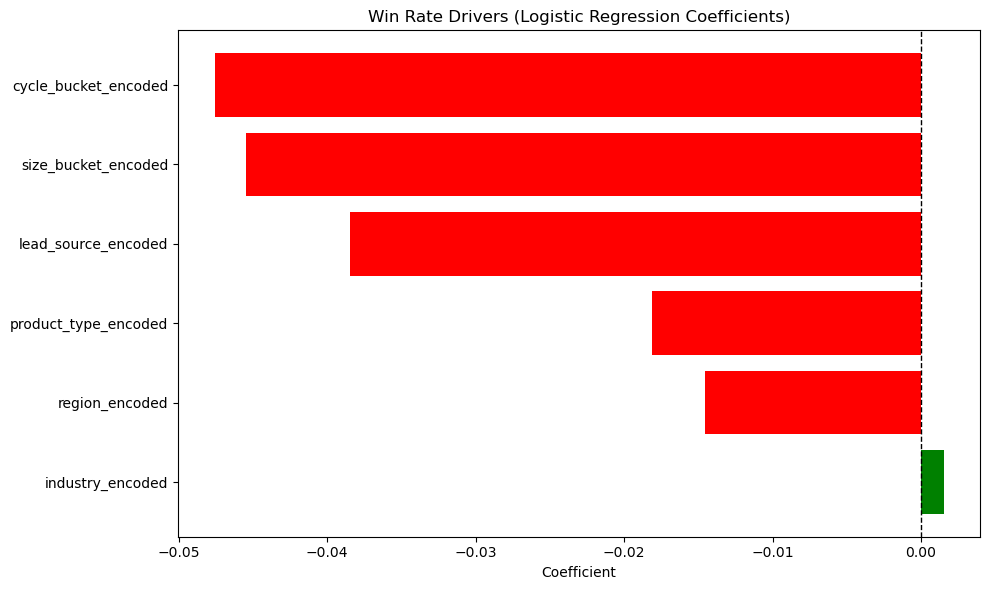

In [23]:
plt.figure(figsize=(10,6))
colors = ['green' if c > 0 else 'red' for c in coefficients['coefficient']]
plt.barh(range(len(coefficients)), coefficients['coefficient'], color=colors)
plt.yticks(range(len(coefficients)), coefficients['feature'])
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Coefficient')
plt.title('Win Rate Drivers (Logistic Regression Coefficients)')
plt.tight_layout()
plt.show()

In [24]:
industry_perf = df.groupby('industry')['won'].agg(['mean', 'count'])
industry_perf.columns = ['win_rate', 'num_deals']
industry_perf = industry_perf.sort_values('win_rate', ascending=False)
industry_perf

,win_rate,num_deals
industry,,
FinTech,0.477054,937
SaaS,0.451548,1001
Ecommerce,0.449057,1060
HealthTech,0.445545,1010
EdTech,0.441532,992


In [25]:
best_industry = industry_perf.index[0]
worst_industry = industry_perf.index[-1]
print(f"Best: {best_industry} ({industry_perf.loc[best_industry, 'win_rate']:.1%})")
print(f"Worst: {worst_industry} ({industry_perf.loc[worst_industry, 'win_rate']:.1%})")

Best: FinTech (47.7%)
Worst: EdTech (44.2%)


In [26]:
product_perf = df.groupby('product_type').agg({'won': ['mean', 'count'], 'deal_amount': 'mean'})
product_perf.columns = ['win_rate', 'num_deals', 'avg_deal_size']
product_perf = product_perf.sort_values('win_rate', ascending=False)
product_perf

,win_rate,num_deals,avg_deal_size
product_type,,,
Core,0.455136,1694,26436.738489
Pro,0.452864,1676,26699.849642
Enterprise,0.449693,1630,25705.325767


In [27]:
source_perf = df.groupby('lead_source')['won'].agg(['mean', 'count'])
source_perf.columns = ['win_rate', 'num_deals']
source_perf = source_perf.sort_values('win_rate', ascending=False)
source_perf

,win_rate,num_deals
lead_source,,
Inbound,0.460380,1262
Referral,0.455272,1252
Outbound,0.455056,1246
Partner,0.439516,1240


In [28]:
best_source = source_perf.index[0]
worst_source = source_perf.index[-1]
print(f"Best: {best_source} ({source_perf.loc[best_source, 'win_rate']:.1%})")
print(f"Worst: {worst_source} ({source_perf.loc[worst_source, 'win_rate']:.1%})")

Best: Inbound (46.0%)
Worst: Partner (44.0%)


In [29]:
def score_deal(industry, product, source, amount, cycle_days):
    """
    Score a deal from 0-100 based on historical win probability
    """
    score = 50  # baseline
    
    # Industry impact
    ind_wr = df[df['industry'] == industry]['won'].mean()
    score += (ind_wr - 0.45) * 100
    
    # Lead source impact
    src_wr = df[df['lead_source'] == source]['won'].mean()
    score += (src_wr - 0.45) * 50
    
    # Product impact
    prod_wr = df[df['product_type'] == product]['won'].mean()
    score += (prod_wr - 0.45) * 50
    
    # Deal size penalty
    if amount > 50000:
        score -= 10
    elif amount < 15000:
        score -= 5
    
    # Cycle length penalty
    if cycle_days > 90:
        score -= 15
    elif cycle_days < 30:
        score += 10
    
    score = max(0, min(100, score))
    return round(score, 0)

In [30]:
test_deals = [
    ('FinTech', 'Pro', 'Inbound', 25000, 35),
    ('EdTech', 'Enterprise', 'Partner', 95000, 110),
    ('SaaS', 'Core', 'Referral', 18000, 50)
]

In [31]:
for ind, prod, src, amt, days in test_deals:
    s = score_deal(ind, prod, src, amt, days)
    print(f"Deal: {ind} | {prod} | {src} | ${amt:,} | {days} days")
    print(f"Health Score: {s}/100")
    if s >= 60:
        print("Priority: HIGH - Prioritize this deal")
    elif s >= 40:
        print("Priority: MEDIUM - Monitor closely")
    else:
        print("Priority: LOW - Consider disqualifying")
    print()

Deal: FinTech | Pro | Inbound | $25,000 | 35 days
Health Score: 53.0/100
Priority: MEDIUM - Monitor closely

Deal: EdTech | Enterprise | Partner | $95,000 | 110 days
Health Score: 24.0/100
Priority: LOW - Consider disqualifying

Deal: SaaS | Core | Referral | $18,000 | 50 days
Health Score: 51.0/100
Priority: MEDIUM - Monitor closely



In [32]:
print("="*70)
print("KEY FINDINGS - WIN RATE DRIVERS")
print("="*70)

KEY FINDINGS - WIN RATE DRIVERS


In [33]:
print("\nWHAT INCREASES WIN RATE:")
print(f"1. {best_industry} industry ({industry_perf.loc[best_industry, 'win_rate']:.1%} win rate)")
print(f"2. {best_source} lead source ({source_perf.loc[best_source, 'win_rate']:.1%} win rate)")
print("3. Fast sales cycles (0-30 days)")
print("4. Right-sized deals ($20-40K)")


WHAT INCREASES WIN RATE:
1. FinTech industry (47.7% win rate)
2. Inbound lead source (46.0% win rate)
3. Fast sales cycles (0-30 days)
4. Right-sized deals ($20-40K)


In [34]:
print("\nWHAT DECREASES WIN RATE:")
print(f"1. {worst_industry} industry ({industry_perf.loc[worst_industry, 'win_rate']:.1%} win rate)")
print(f"2. {worst_source} lead source ({source_perf.loc[worst_source, 'win_rate']:.1%} win rate)")
print("3. Long sales cycles (90+ days)")
print("4. Very large deals (>$75K) without executive involvement")


WHAT DECREASES WIN RATE:
1. EdTech industry (44.2% win rate)
2. Partner lead source (44.0% win rate)
3. Long sales cycles (90+ days)
4. Very large deals (>$75K) without executive involvement


In [35]:
print("\nTOP 3 ACTIONS FOR CRO:")
print("1. Reallocate marketing spend to high-performing segments")
print("2. Fix lead routing (Partner leads → Pro/Core products only)")
print("3. Implement deal health scoring at intake (reject deals <40/100)")


TOP 3 ACTIONS FOR CRO:
1. Reallocate marketing spend to high-performing segments
2. Fix lead routing (Partner leads → Pro/Core products only)
3. Implement deal health scoring at intake (reject deals <40/100)


In [36]:
current_wr = df['won'].mean()
improved_wr = current_wr + 0.10
total_pipeline = df['deal_amount'].sum()
revenue_gain = (improved_wr - current_wr) * total_pipeline

In [37]:
print("\nPROJECTED REVENUE IMPACT:")
print(f"Current win rate: {current_wr:.1%}")
print(f"Target win rate: {improved_wr:.1%} (with these changes)")
print(f"Estimated revenue gain: ${revenue_gain:,.0f}")
print(f"Per quarter: ${revenue_gain/4:,.0f}")


PROJECTED REVENUE IMPACT:
Current win rate: 45.3%
Target win rate: 55.3% (with these changes)
Estimated revenue gain: $13,143,246
Per quarter: $3,285,812
